In [35]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np

from disp import set_font_size, set_n_x_ticks
from replay import smln, plot, analysis


XYS_RASTER = [
    (-.75, .75), (-.5, .75), (-.25, .75), (0, .75),
    (0, .5), (0, .25), (0, 0), (0, -.25), (0, -.5),
    (0, -.75), (.25, -.75), (.5, -.75), (.75, -.75)
]

# ANALYSIS
A_PARAMS = {
    'MIN_DUR_SPD_CALC': 0.05,  # s
    'SPD_CALC_TRNC_FRAC': 0.1,  # fraction
    'MIN_START': 0.075,  # s
    'MIN_EVT_DUR_PSD': 0.05,  # s
    'MAX_EVT_DUR_PSD': 0.25,  # s
}

P_PARAMS = {
    'T': 0.3,  # max SWR duration
    'FRQ_MAX': 250,  # Hz (max frq to show on PSD plot)
}

In [36]:
def rerun_smln(f_name, smln_id, rng_seed, d_smln=None, epochs=None, t_lim=None):
    
    df, rslts, header = analysis.make_df(f_name)
    
    if epochs is None:
        epochs = []
        
    # rerun smln
    m_params = copy(header['m_params'])
    s_params = copy(header['s_params'])

    rslt = rslts[smln_id]
    assert rslt['SMLN_ID'] == smln_id

    for param in header['params_varied']:
        m_params[param] = rslt['PARAMS'][param]

    s_params['RNG_SEED'] = rng_seed
    if d_smln is not None:
        s_params['schedule']['D_SMLN'] = d_smln

    print('Running smln...')
    rslt_rerun = smln.run(m_params, s_params)
    print('Smln complete.')

    # analyze results
    print('Desired metrics:')
    print(rslt['METRICS'][str(rng_seed)])
    print('Actual metrics:')
    print(analysis.get_metrics(rslt_rerun, header['a_params']))

    # plot results
    ## potentiation profile
    ax, c_ax = plot.ltp_ie_profile(rslt_rerun)

    ## add PC labels
    for ctr, (x, y) in enumerate(XYS_RASTER):
        ax.text(x, y, str(ctr), fontsize=14, horizontalalignment='center', verticalalignment='center')

    ## selected replay epoch spike sequences
    for epoch in epochs:
        fig, axs = plot.spike_seq(rslt_rerun, epoch=epoch)

    ## raster for selected PCs
    fig, axs = plot.raster_with_pc_inh(
        rslt_rerun,
        XYS_RASTER,
        colors=np.zeros(len(XYS_RASTER)),
        cmap='inferno',
        nearest=1,
        epoch=(0, 10),
        trg_plt=[],
        y_lim=(-1, 13),
        y_ticks=[0, 3, 6, 9, 12],
        smoothness=4)
    
    if t_lim is not None:
        for ax in axs:
            ax.set_xlim(t_lim)

    ## shade selected replay epochs
    for epoch in epochs:
        axs[0].axvspan(*epoch, color='b', alpha=0.15)
        axs[1].axvspan(*epoch, color='b', alpha=0.15)
        axs[2].axvspan(*epoch, color='b', alpha=0.15)
    
    rslt_rerun.a_params = copy(header['a_params'])
    for a_param, a_param_val in A_PARAMS.items():
        rslt_rerun.a_params[a_param] = a_param_val
    
    return rslt_rerun

In [62]:
def plot_swr_psd(rslts, a_params, p_params, colors=None, evt_alpha=0.1):
    """Plot power spectral density of all SWRs extracted from smln rslt."""
    
    if colors is None:
        colors = ['k'] * len(rslts)

    T = p_params['T']
    frq_max = p_params['FRQ_MAX']

    fig, axs = plt.subplots(3, 2, figsize=(14, 12), tight_layout=True)
    
    for rslt, color in zip(rslts, colors):
        n_frq = int(np.round(T/rslt.s_params['DT']))
        frq = np.fft.fftfreq(n_frq, rslt.s_params['DT'])

        frq_stop_idx = int(np.round(len(frq)/2))

        # get power spectra for all events
        starts, ends = analysis.get_evts(rslt, a_params)
        print('Starts:', starts)
        print('Ends:', ends)

        # get rid of invalid events
        durs = ends - starts
        mask = (a_params['MIN_EVT_DUR_PSD'] <= durs) & (durs < a_params['MAX_EVT_DUR_PSD'])
        
        starts = starts[mask]
        ends = ends[mask]
        
        if not len(starts):
            print('No valid SWRs detected for result "{}"'.format(color))
            continue
            
        # loop over events
        psds_full = []
        psds_pc = []
        psds_inh = []

        for start, end in zip(starts, ends):

            # get spikes
            t_mask = (start <= rslt.ts) & (rslt.ts < end)
            pc_mask = rslt.ntwk.types_rcr == 'PC'
            inh_mask = rslt.ntwk.types_rcr == 'INH'

            # get spks and time vec
            t_swr = rslt.ts[t_mask] - start

            spks_full = rslt.spks[t_mask].mean(axis=1)
            spks_pc = rslt.spks[t_mask][:, pc_mask].mean(axis=1)
            spks_inh = rslt.spks[t_mask][:, inh_mask].mean(axis=1)

            # remove DC components
            spks_full -= np.mean(spks_full)
            spks_pc -= np.mean(spks_pc)
            spks_inh -= np.mean(spks_inh)

            # calc PSDs
            psd_full = np.abs(np.fft.fft(spks_full, n_frq))**2
            psd_pc = np.abs(np.fft.fft(spks_pc, n_frq))**2
            psd_inh = np.abs(np.fft.fft(spks_inh, n_frq))**2

            for spks, psd, label, ax_row in zip(
                    [spks_full, spks_pc, spks_inh], [psd_full, psd_pc, psd_inh], ['FULL', 'PC', 'INH'], axs):

                # time-domain
                ax_row[0].plot(t_swr, spks, lw=2)
                ax_row[0].set_xlabel('Time (s)')
                ax_row[0].set_ylabel('Spk ct')
                ax_row[0].set_title('{} SWR'.format(label))

                # frq-domain
                ax_row[1].plot(frq[:frq_stop_idx], psd[:frq_stop_idx], lw=1, c=color, alpha=evt_alpha)
                ax_row[1].set_xlabel('Frequency (Hz)')
                ax_row[1].set_ylabel('Power (Hz)')
                ax_row[1].set_title('{} PSD'.format(label))

            for ax in axs.flatten():
                set_font_size(ax, 16)

            psds_full.append(psd_full)
            psds_pc.append(psd_pc)
            psds_inh.append(psd_inh)

        for psds, ax in zip([psds_full, psds_pc, psds_inh], axs[:, 1]):
            psds_mean = np.mean(psds, axis=0)
            ax.plot(frq[:frq_stop_idx], psds_mean[:frq_stop_idx], lw=4, c=color)
            ax.set_xlim(0, frq_max)
            
    return fig, axs

# Speed overlay for two different parameter regimes
Show overlaid replay speed calculations for example events.

SLOW: SWEEP 0: EXT_ID: 66: W_PC_PC = 0.026, L_PC_PC = 0.0504 (ORIG_SMLN_ID: 134)

FAST: SWEEP 0: EXT_ID: 72: W_PC_PC = 0.026, L_PC_PC = 0.0582 (ORIG_SMLN_ID: 140)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running smln...
Smln complete.
Desired metrics:
{'evt_ct': 21, 'fr_ntrj': 0.14939963059792205, 'one_way_ct': 11, 'evt_dur': 0.09911904761904765, 'fr_trj': 4.457509918333893}
Actual metrics:
{'one_way_ct': 7, 'evt_ct': 14, 'fr_ntrj': 0.1552203966512468, 'fr_trj': 4.392077490530281, 'evt_dur': 0.08839285714285716}


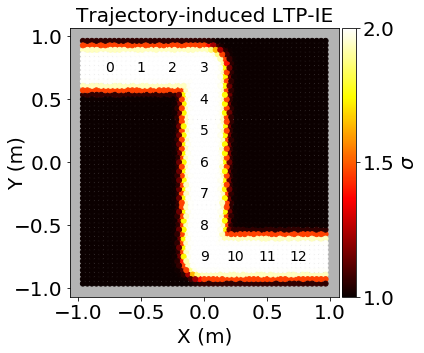

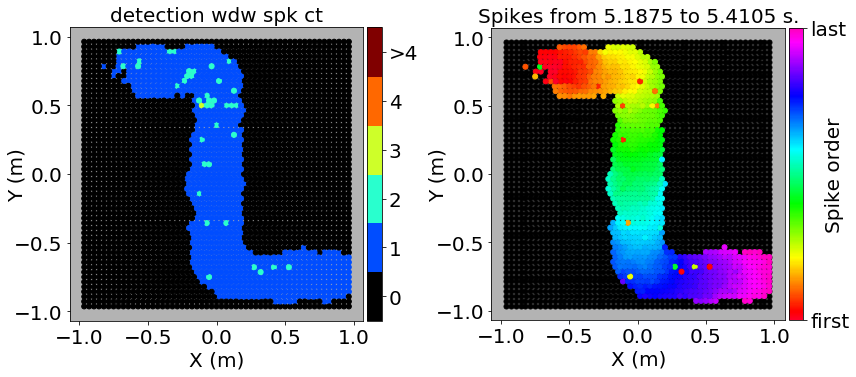

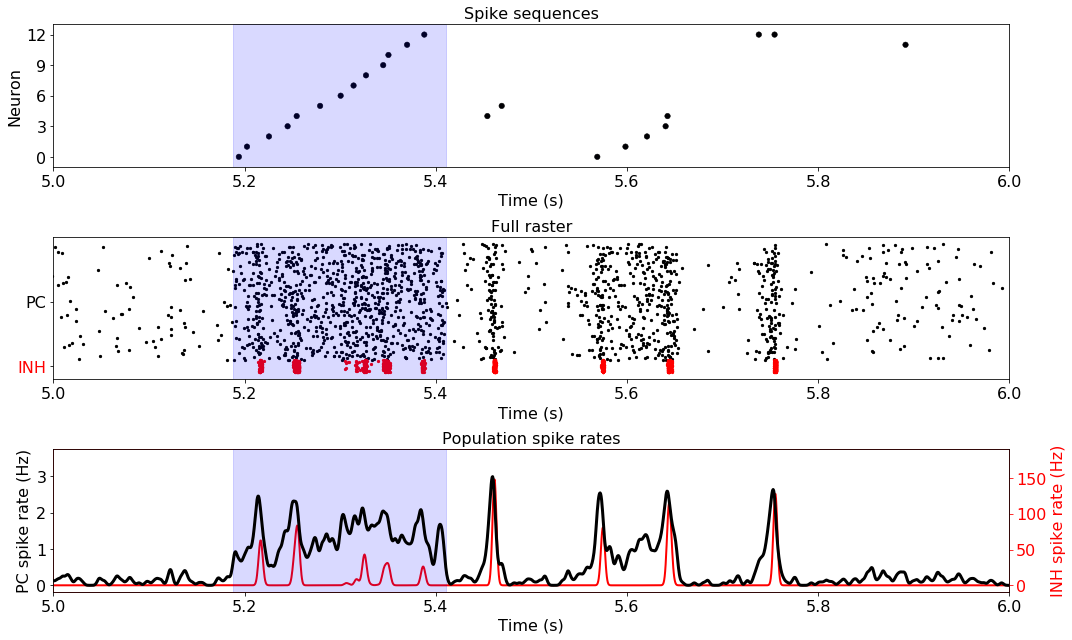

In [4]:
rslt_slow = rerun_smln('PARAM_SWEEP_RESULTS_0_W_PC_PC_L_PC_PC.txt', 134, 4, d_smln=6, epochs=[(5.1875, 5.4105)], t_lim=(5, 6))
evts_slow = analysis.get_evts(rslt_slow, rslt_slow.a_params)

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running smln...
Smln complete.
Desired metrics:
{'evt_ct': 36, 'fr_ntrj': 0.710382606703208, 'one_way_ct': 24, 'evt_dur': 0.13631944444444447, 'fr_trj': 6.289421780328172}
Actual metrics:
{'one_way_ct': 8, 'evt_ct': 12, 'fr_ntrj': 0.680680545001923, 'fr_trj': 6.312630324761824, 'evt_dur': 0.12608333333333333}


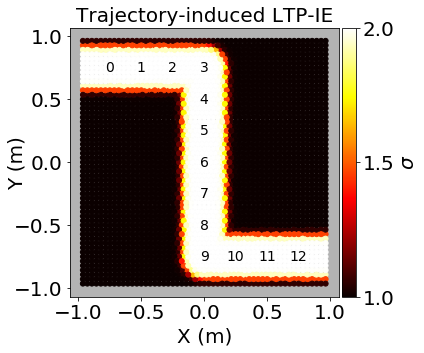

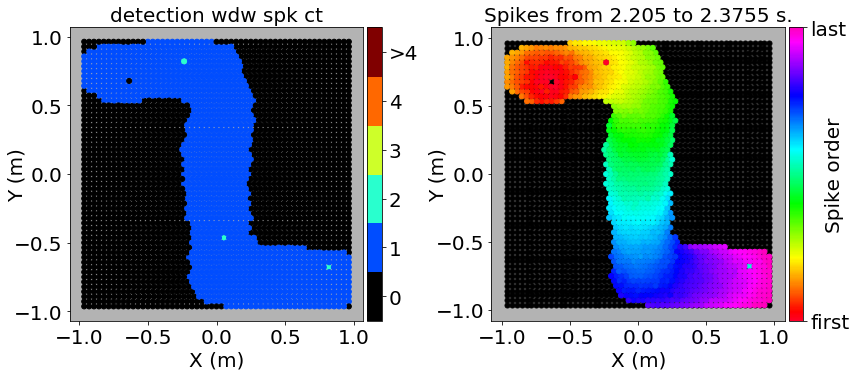

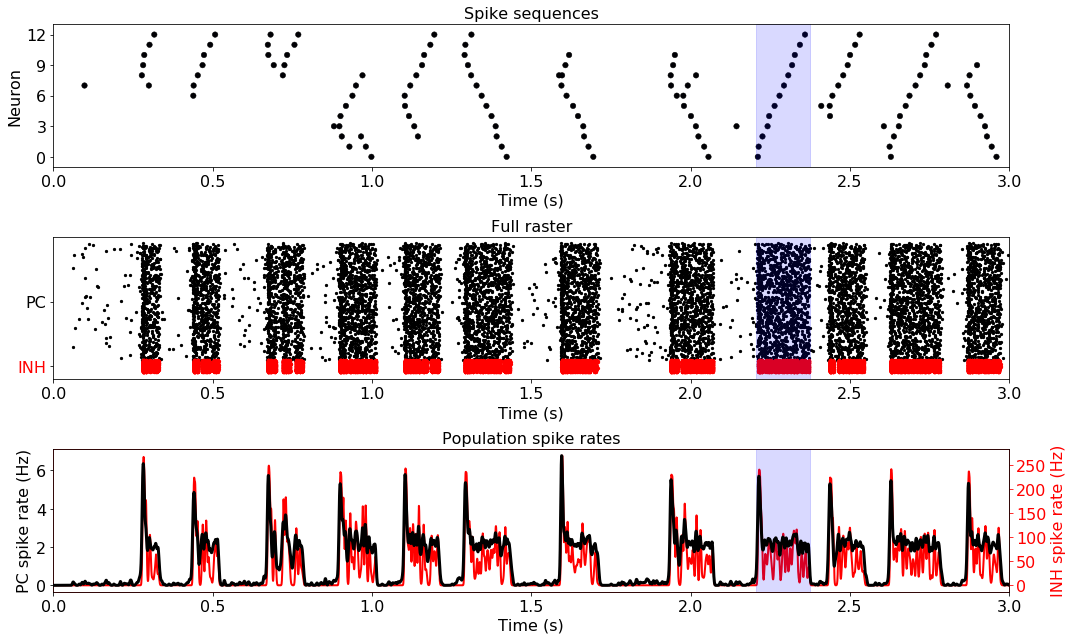

In [5]:
rslt_fast = rerun_smln('PARAM_SWEEP_RESULTS_0_W_PC_PC_L_PC_PC.txt', 140, 3, d_smln=3, epochs=[(2.205, 2.3755)], t_lim=(0, 3))
evts_fast = analysis.get_evts(rslt_fast, rslt_fast.a_params)

In [6]:
print('Slow replay events:')
print('Starts:', evts_slow[0])
print('Ends:', evts_slow[1])

print('Fast replay events:')
print('Starts:', evts_fast[0])
print('Ends:', evts_fast[1])

Slow replay events:
Starts: [0.1945 0.809  1.4085 1.7015 2.073  2.4485 2.81   2.8785 2.9875 3.3515
 3.997  4.217  4.8945 5.1875 5.559 ]
Ends: [0.251  0.871  1.515  1.799  2.1505 2.523  2.8555 2.938  3.1    3.392
 4.105  4.307  4.94   5.4105 5.654 ]
Fast replay events:
Starts: [0.272  0.4325 0.6665 0.892  1.0955 1.285  1.5885 1.931  2.205  2.429
 2.6205 2.864 ]
Ends: [0.3355 0.5215 0.787  1.015  1.215  1.441  1.7135 2.073  2.3755 2.5515
 2.7895 2.9765]


In [7]:
# calc speeds for selected events
epoch_slow = (5.1875, 5.4105)
epoch_fast = (2.205, 2.3755)

spd_slow, slow = analysis.calc_spd(rslt_slow, *epoch_slow, rslt_slow.a_params, debug=True)
spd_fast, fast = analysis.calc_spd(rslt_fast, *epoch_fast, rslt_fast.a_params, debug=True)

Speed slow: 14.264251114326774 m/s
Speed fast: 18.816717291872173 m/s


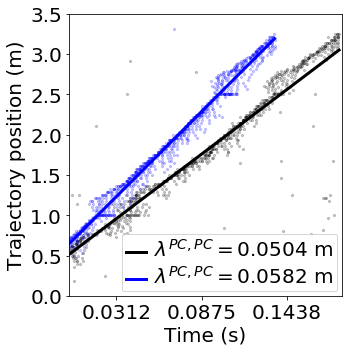

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

# scatters
x_line = np.array([slow['ts_spk'][0], slow['ts_spk'][-1]])
y_line = slow['slp']*x_line + slow['icpt']
ax.plot(x_line - np.min(slow['ts_spk']), y_line, c='k', lw=3)

x_line = np.array([fast['ts_spk'][0], fast['ts_spk'][-1]])
y_line = fast['slp']*x_line + fast['icpt']
ax.plot(x_line - np.min(fast['ts_spk']), y_line, c='b', lw=3)

ax.legend([
    '$\lambda^{PC,PC} = $' + '{0:.4f} m'.format(rslt_slow.p['L_PC_PC']),
    '$\lambda^{PC,PC} = $' + '{0:.4f} m'.format(rslt_fast.p['L_PC_PC']),
])

ax.scatter(slow['ts_spk'] - np.min(slow['ts_spk']), slow['ds_trj_spk'], c='k', s=5, alpha=0.2)
ax.scatter(fast['ts_spk'] - np.min(fast['ts_spk']), fast['ds_trj_spk'], c='b', s=5, alpha=0.2)

set_n_x_ticks(ax, 5)
ax.set_xlim(0, 0.18)
ax.set_ylim(0, 3.5)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Trajectory position (m)')

set_font_size(ax, 20)

print('Speed slow: {} m/s'.format(spd_slow))
print('Speed fast: {} m/s'.format(spd_fast))

# Plot example PSDs

### SWEEP 1

RSLTS from PARAM_SWEEP_RESULTS_1_W_PC_PC_W_PC_INH.txt.

0: W_PC_PC = 0.026, W_PC_INH = 0.00012, SMLN_ID 90, RNG_SEED 0

1: W_PC_PC = 0.026, W_PC_INH = 0.00027, SMLN_ID 195, RNG_SEED 1

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running smln...
Smln complete.
Desired metrics:
{'one_way_ct': 19, 'evt_ct': 30, 'evt_dur': 0.1331333333333333, 'fr_trj': 5.7534099983656874, 'fr_ntrj': 0.3797896423438821}
Actual metrics:
{'one_way_ct': 19, 'evt_ct': 30, 'fr_ntrj': 0.3797896423438821, 'fr_trj': 5.7534099983656874, 'evt_dur': 0.1331333333333333}


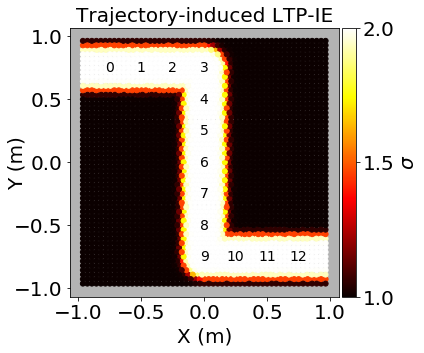

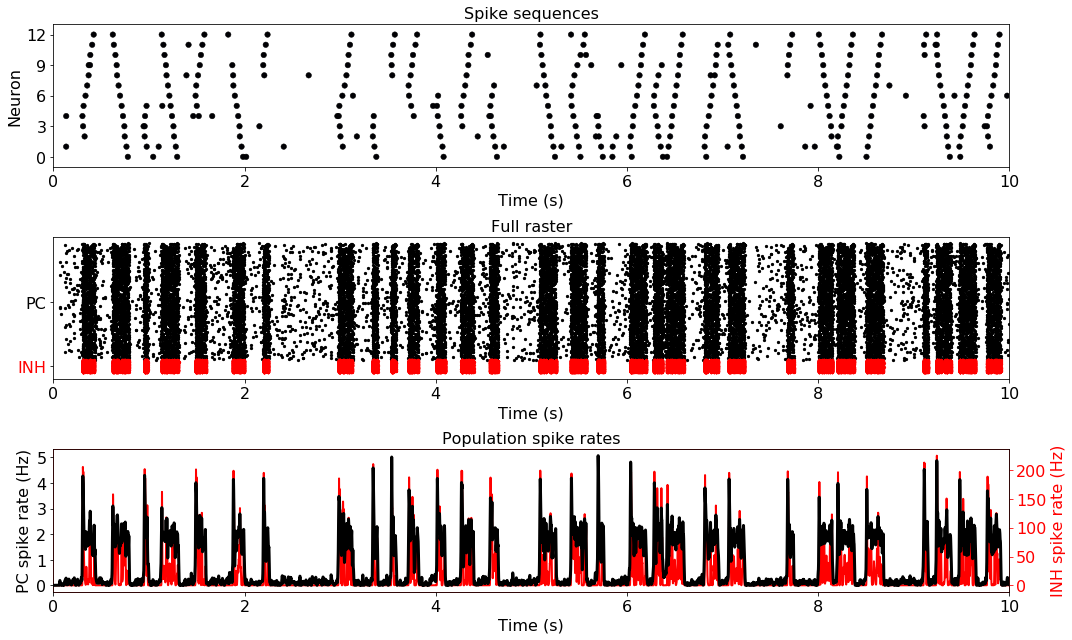

In [57]:
rslt_0 = rerun_smln('PARAM_SWEEP_RESULTS_1_W_PC_PC_W_PC_INH.txt', 90, 0, d_smln=10, t_lim=(0, 10))

/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Running smln...
Smln complete.
Desired metrics:
{'one_way_ct': 19, 'evt_ct': 23, 'evt_dur': 0.13115217391304362, 'fr_trj': 4.900497767548492, 'fr_ntrj': 0.2706192093976913}
Actual metrics:
{'one_way_ct': 19, 'evt_ct': 23, 'fr_ntrj': 0.2706192093976913, 'fr_trj': 4.900497767548492, 'evt_dur': 0.13115217391304362}


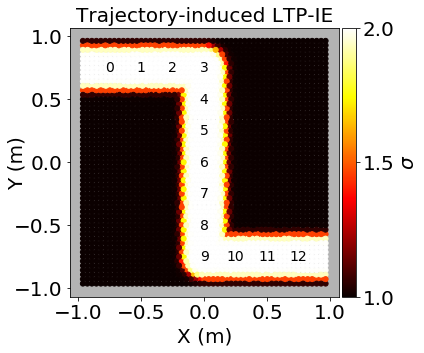

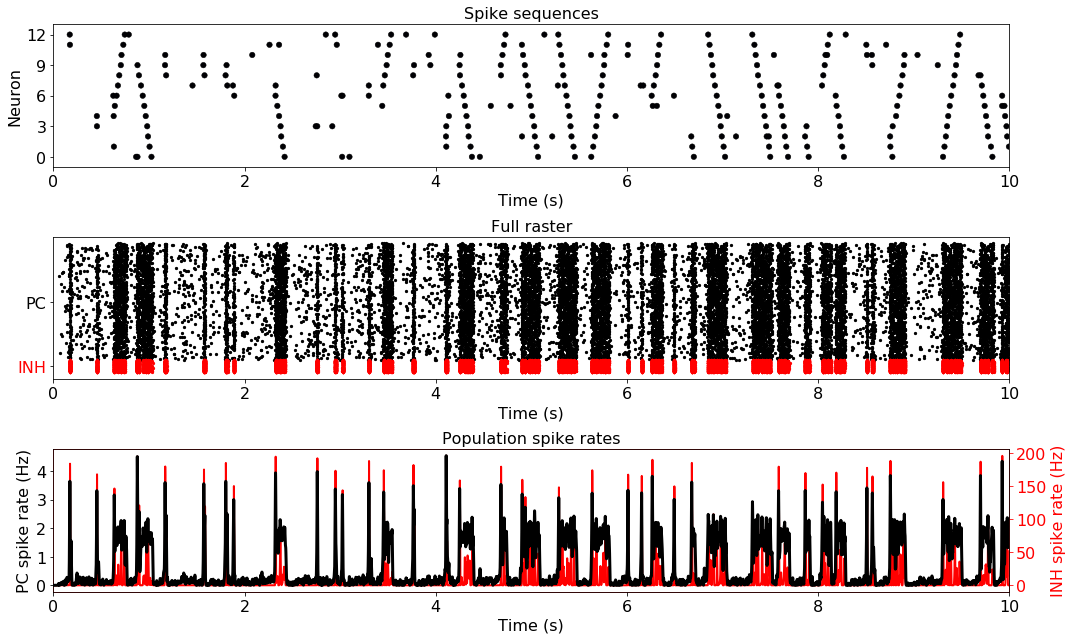

In [58]:
rslt_1 = rerun_smln('PARAM_SWEEP_RESULTS_1_W_PC_PC_W_PC_INH.txt', 195, 1, d_smln=10, t_lim=(0, 10))

Starts: [0.2995 0.6135 0.9445 1.123  1.4805 1.872  2.191  2.976  3.336  3.53
 3.711  4.006  4.26   4.5615 5.0835 5.4105 5.6875 6.0235 6.275  6.4035
 6.806  7.061  7.6735 8.001  8.195  8.5005 9.097  9.231  9.4745 9.7635]
Ends: [0.4415 0.795  0.9975 1.313  1.5965 2.0005 2.2595 3.141  3.3945 3.59
 3.8225 4.0995 4.3985 4.657  5.262  5.577  5.762  6.2075 6.3825 6.601
 6.963  7.2345 7.7475 8.155  8.383  8.687  9.1535 9.3965 9.6525 9.914 ]


/home/rkp/miniconda3/envs/sci/lib/python3.5/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)


Starts: [0.6275 0.869  1.791  2.315  3.4415 4.096  4.2425 4.6725 4.885  5.271
 5.6255 6.258  6.67   6.838  7.305  7.578  7.8575 8.034  8.1815 8.5575
 8.7485 9.2975 9.692 ]
Ends: [0.7695 1.042  1.824  2.4355 3.5495 4.1405 4.3975 4.75   5.0905 5.477
 5.822  6.3765 6.719  7.0445 7.5225 7.7035 7.919  8.139  8.2885 8.5955
 8.9165 9.506  9.842 ]


(0, 0.001)

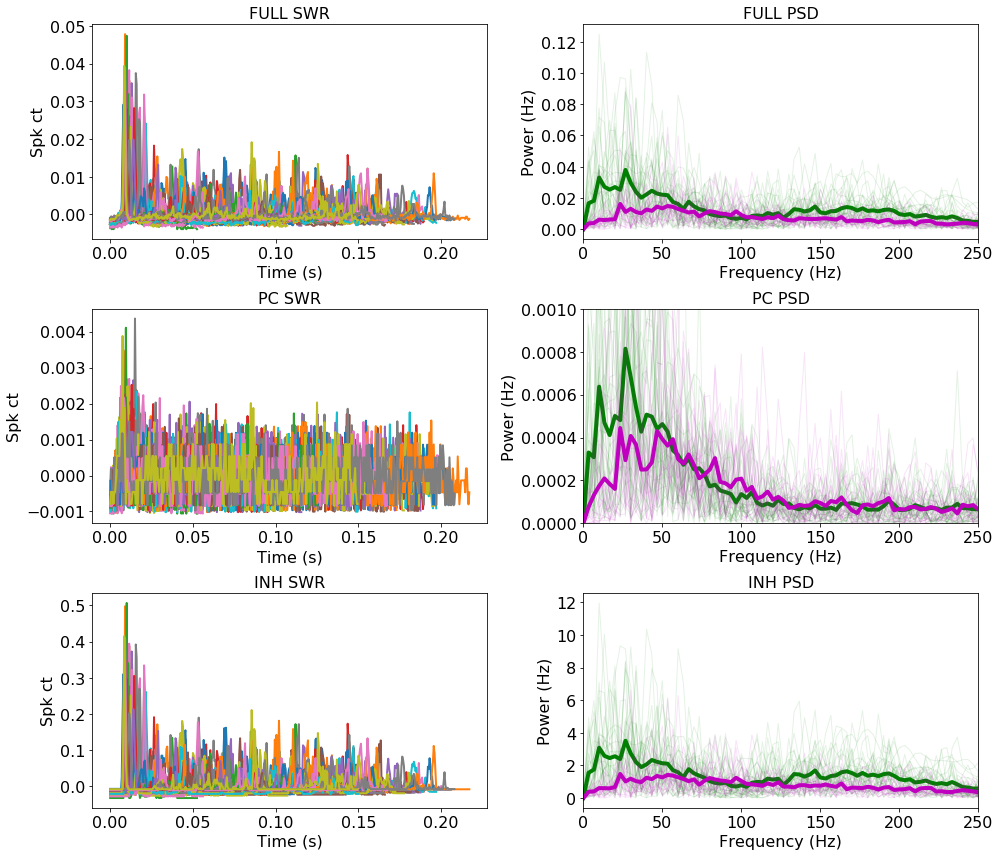

In [63]:
axs = plot_swr_psd([rslt_0, rslt_1], rslt_0.a_params, P_PARAMS, colors=['g', 'm'], evt_alpha=0.1)[1]
axs[1, 1].set_ylim(0, 0.001)